In [ ]:
!pip install -q transformers datasets scikit-learn evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import evaluate
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fake_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake.csv')
real_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/True.csv')


In [ ]:
# Add labels
fake_df["label"] = 1
real_df["label"] = 0

# Combine datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Remove duplicate texts
df.drop_duplicates(subset="text", inplace=True)

# Shuffle and reset index
df = df.sample(frac=1).reset_index(drop=True)

# Keep only text and label
df = df[["text", "label"]]

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_data(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(df)

# Split: 70% train, 30% test
dataset = dataset.train_test_split(test_size=0.3)

# Tokenize
train_dataset = dataset["train"].map(tokenize_data, batched=True)
test_dataset = dataset["test"].map(tokenize_data, batched=True)

# Format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/27052 [00:00<?, ? examples/s]

Map:   0%|          | 0/11594 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
    preds = np.argmax(logits, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
        "auc": roc_auc_score(labels, probs),
    }


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    # Replace 'evaluation_strategy' with 'eval_strategy'
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=False
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()
metrics = trainer.evaluate()

print("Final Evaluation Metrics:")
print(metrics)


<ipython-input-9-6d2c95e9bd45>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thundurthythriveedh (thundurthythriveedh-iiitdm-kancheepuram) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc
1,0.000000,0.002382,0.999655,0.999619,0.999619,0.999619,1.000000
2,0.000000,0.002252,0.999827,0.999619,1.000000,0.999809,0.999994
3,0.000000,0.002373,0.999827,0.999619,1.000000,0.999809,0.999996


Final Evaluation Metrics:
{'eval_loss': 0.002373024821281433, 'eval_accuracy': 0.9998274969811972, 'eval_precision': 0.9996187571483035, 'eval_recall': 1.0, 'eval_f1': 0.999809342230696, 'eval_auc': 0.9999963663008943, 'eval_runtime': 344.2658, 'eval_samples_per_second': 33.677, 'eval_steps_per_second': 4.212, 'epoch': 3.0}


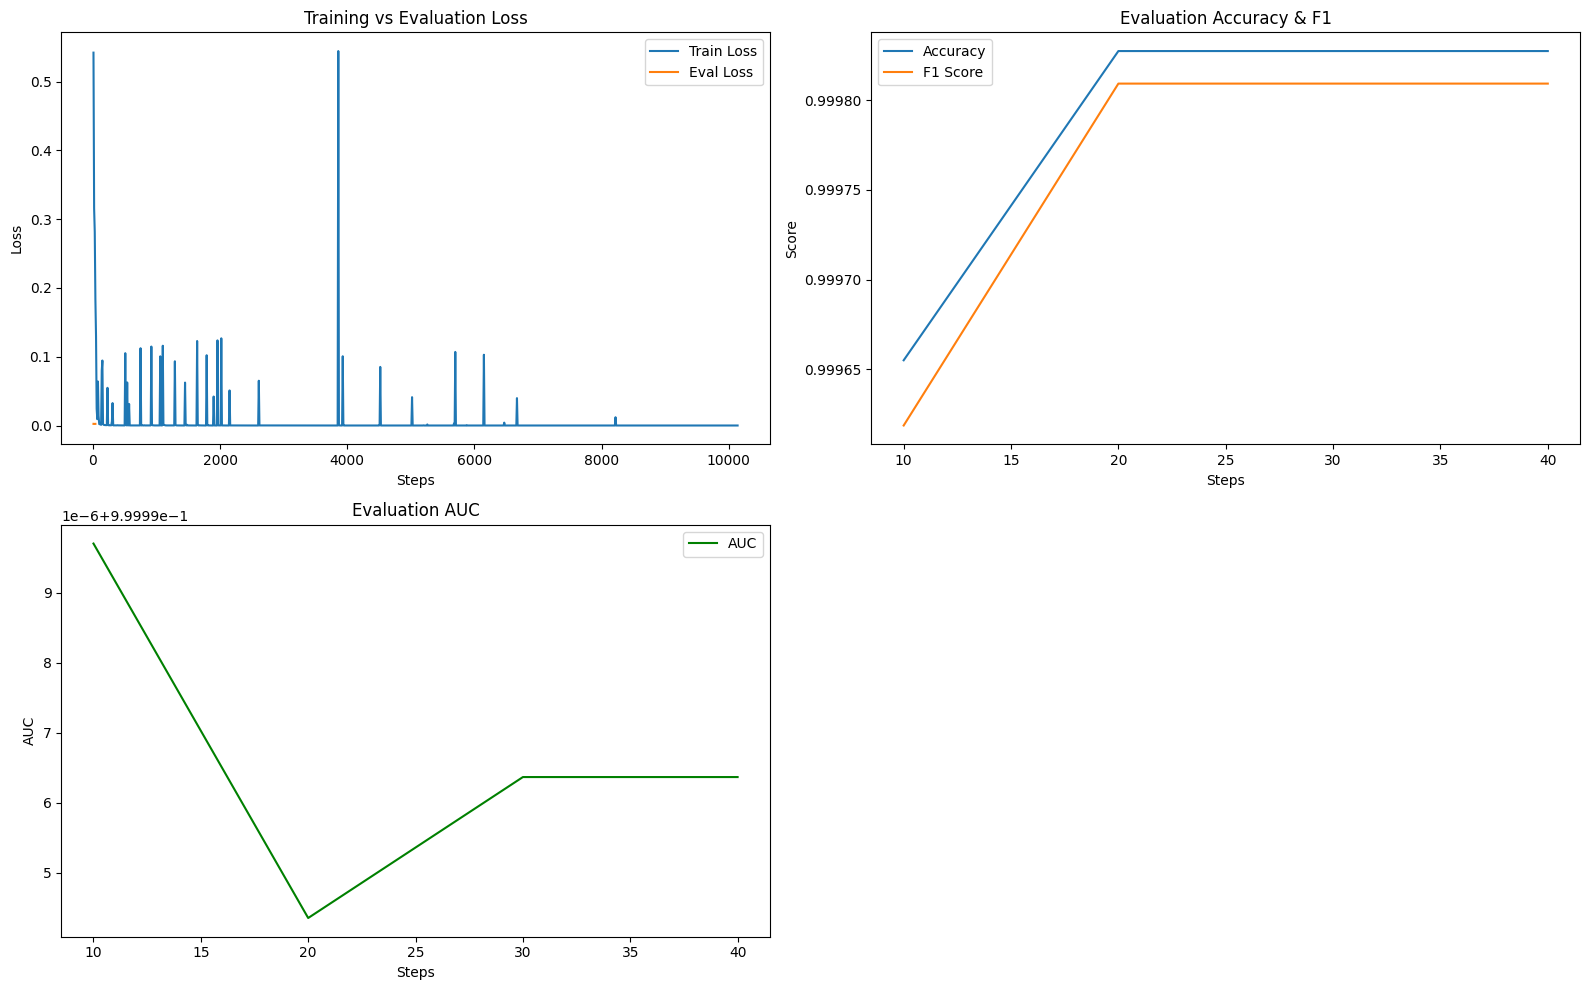

In [ ]:
# Extract logs
log_history = trainer.state.log_history

# Prepare metrics lists
train_loss, eval_loss, eval_acc, eval_f1, eval_auc, steps = [], [], [], [], [], []

for entry in log_history:
    if 'loss' in entry and 'epoch' in entry:
        train_loss.append(entry['loss'])
        steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        eval_acc.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])
        eval_auc.append(entry['eval_auc'])

# Plotting
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(steps[:len(train_loss)], train_loss, label='Train Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Eval Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Evaluation Loss")

plt.subplot(2, 2, 2)
plt.plot(steps[:len(eval_acc)], eval_acc, label='Accuracy')
plt.plot(steps[:len(eval_f1)], eval_f1, label='F1 Score')
plt.xlabel("Steps")
plt.ylabel("Score")
plt.legend()
plt.title("Evaluation Accuracy & F1")

plt.subplot(2, 2, 3)
plt.plot(steps[:len(eval_auc)], eval_auc, label='AUC', color='green')
plt.xlabel("Steps")
plt.ylabel("AUC")
plt.legend()
plt.title("Evaluation AUC")

plt.tight_layout()
plt.show()
